In [1]:
import sys
sys.stdout = open('/dev/stdout', 'w')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import simpy
import numpy as np
import pandas as pd
from ggplot import *
from collections import namedtuple

%run docket.py

In [2]:
HOURS_IN_A_YEAR = 260*8
NUM_JUDGES = 100
JUDGE_TENURES = [HOURS_IN_A_YEAR * -1, HOURS_IN_A_YEAR * -5, HOURS_IN_A_YEAR * -99]
NUM_ATTORNEYS_PER_JUDGE_BY_TENURE = [6, 7, 8]
VAR_ATTORNEYS_PER_JUDGE = 1
AVG_NUM_ATTORNEYS_PER_JUDGE = np.mean(NUM_ATTORNEYS_PER_JUDGE_BY_TENURE)
BVA_ANNUAL_THROUGHPUT = 90000
AVG_ATTORNEY_HOURS_PER_CASE = 1 / (BVA_ANNUAL_THROUGHPUT / (NUM_JUDGES * AVG_NUM_ATTORNEYS_PER_JUDGE) / HOURS_IN_A_YEAR)
SD_ATTORNEY_HOURS_PER_CASE = 3
AVG_ARRIVAL_INTERVAL = 1 / (BVA_ANNUAL_THROUGHPUT / HOURS_IN_A_YEAR)
SD_ARRIVAL_INTERVAL = AVG_ARRIVAL_INTERVAL * 0.2
HEARING_RATE = 0.5
PRIORITY_CASE_RATE = 0.2
REMAND_RATE = 0.5
INIT_NUM_CASES = 30000
INIT_HEARING_RATE = 0.5
INIT_PRIORITY_CASE_RATE = 0.02
INIT_REMAND_RATE = 0.25
AVG_AGE_AT_ARRIVAL = HOURS_IN_A_YEAR * 2
SD_AGE_AT_ARRIVAL = HOURS_IN_A_YEAR * 1
AVG_REMAND_AGE_AT_ARRIVAL = HOURS_IN_A_YEAR * 5
SD_REMAND_AGE_AT_ARRIVAL = HOURS_IN_A_YEAR * 2.5
AGE_AT_HEARING = HOURS_IN_A_YEAR * 2

In [3]:
BATCH_SIZE_PER_ATTORNEY = 5

In [4]:
env = simpy.Environment()

In [5]:
Judge = namedtuple('Judge', 'id tenure attorneys')
judges = [Judge(i, np.random.choice(JUDGE_TENURES), []) for i in range(NUM_JUDGES)]

In [6]:
class Appeal(namedtuple('Appeal', 'judge priority docketed arrived')):
    def __lt__(self, other):
        return self.docketed < other.docketed
    
class PriorityAppeal(namedtuple('PriorityAppeal', 'judge priority docketed arrived')):
    def __lt__(self, other):
        return self.arrived < other.arrived

def generate_appeal(hearing_prob, priority_prob, remand_prob, now):
    judge = None
    hearing = np.random.rand() < hearing_prob
    priority = np.random.rand() < priority_prob
    remand = np.random.rand() < remand_prob
    docketed = now - (np.random.normal(AVG_REMAND_AGE_AT_ARRIVAL, SD_REMAND_AGE_AT_ARRIVAL) if remand else np.random.normal(AVG_AGE_AT_ARRIVAL, SD_AGE_AT_ARRIVAL))
    if hearing:
        valid_judges = [j for j in judges if j.tenure <= docketed + AGE_AT_HEARING]
        judge = valid_judges[np.random.randint(1, len(valid_judges)) - 1]
    if priority:
        return PriorityAppeal(judge, priority, docketed, now)
    return Appeal(judge, priority, docketed, now)

In [7]:
Attorney = namedtuple('Attorney', 'id judge store')
attorneys = []

for judge in judges:
    tenure_idx = JUDGE_TENURES.index(judge.tenure)
    num_attorneys = NUM_ATTORNEYS_PER_JUDGE_BY_TENURE[tenure_idx] +\
        np.random.randint(-VAR_ATTORNEYS_PER_JUDGE, VAR_ATTORNEYS_PER_JUDGE)
    for i in range(num_attorneys):
        store = simpy.Store(env)
        num_cases = np.random.randint(2, BATCH_SIZE_PER_ATTORNEY + 2)
        store.items = [generate_appeal(0, 0, 0, 0) for i in range(num_cases)]
        attorney = Attorney("%d-%d" % (judge.id, i), judge, store)
        judge.attorneys.append(attorney)
        attorneys.append(attorney)

In [8]:
legacy_docket = Docket(env)
legacy_docket.prepopulate([generate_appeal(INIT_HEARING_RATE, INIT_PRIORITY_CASE_RATE, INIT_REMAND_RATE, 0)
                           for i in range(INIT_NUM_CASES)])

True

In [9]:
def instrumented_get_nonpriority_appeals(docket, judge = None, limit = sys.maxsize, range = sys.maxsize):
    if not isinstance(judge, list):
        judge = [judge]

    indices = [idx for idx, item in enumerate(docket.items[:range]) if item.judge in judge]
    limited_indices = indices[:limit]
    appeals = yield docket.get(limited_indices)
    return appeals, max(limited_indices, default = 0)

In [10]:
def select_appeals_for_judge(judge, env, docket, data):
    batch_size = len(judge.attorneys) * BATCH_SIZE_PER_ATTORNEY
    total_batch_size = len(attorneys) * BATCH_SIZE_PER_ATTORNEY

    total_count = docket.count()
    priority_count = docket.priority_count()
    net_docket_range = max(total_batch_size - priority_count, 0)
    target_num_priority_appeals = int(np.ceil(min(priority_count / total_batch_size, 1) * batch_size))

    rem = batch_size

    priority_hearing_appeals = yield docket.get_priority_appeals(judge = judge, limit = rem)
    rem -= len(priority_hearing_appeals)

    # nonpriority_hearing_appeals = yield docket.get_nonpriority_appeals(judge = judge,
    #                                                                    limit = rem,
    #                                                                    range = net_docket_range)
    nonpriority_hearing_appeals, max_index_1 = yield from instrumented_get_nonpriority_appeals(docket = docket,
                                                                                               judge = judge,
                                                                                               limit = rem,
                                                                                               range = net_docket_range)
    rem -= len(nonpriority_hearing_appeals)
    
    priority_rem = min(max(target_num_priority_appeals - len(priority_hearing_appeals), 0), rem)
    priority_nonhearing_appeals = yield docket.get_priority_appeals(limit = priority_rem)
    rem -= len(priority_nonhearing_appeals)
    
    # nonpriority_appeals = yield docket.get_nonpriority_appeals(judge = [None, judge], limit = rem)
    nonpriority_appeals, max_index_2 = yield from instrumented_get_nonpriority_appeals(docket = docket,
                                                                                       judge = [None, judge],
                                                                                       limit = rem)
    
    selected_appeals = priority_hearing_appeals + \
        nonpriority_hearing_appeals + \
        priority_nonhearing_appeals + \
        nonpriority_appeals
    
    data['distribution_batches'].append({
        'time': env.now,
        'judge_id': judge.id,
        'judge_tenure': judge.tenure / -HOURS_IN_A_YEAR,
        'total_available': total_count,
        'priority_available': priority_count,
        'requested': batch_size,
        'total_dist': len(selected_appeals),
        'hearing_dist': sum(appeal.judge is not None for appeal in selected_appeals),
        'priority_dist': len(priority_hearing_appeals) + len(priority_nonhearing_appeals),
        'max_index': max(max_index_1, max_index_2)
    })
    
    for appeal in selected_appeals:
        data['distribution_cases'].append({
            'time': env.now,
            'arrived': appeal.arrived,
            'priority': appeal.priority,
            'hearing': appeal.judge is not None
        })
    
    return selected_appeals

In [11]:
def legacy_appeal_arrives(env, docket):
    while True:
        interval = abs(np.random.normal(AVG_ARRIVAL_INTERVAL, SD_ARRIVAL_INTERVAL))
        yield env.timeout(interval)
        yield docket.put(generate_appeal(HEARING_RATE, PRIORITY_CASE_RATE, REMAND_RATE, env.now))
        # print('Added a new appeal', 'at', env.now)

arrival_proc = env.process(legacy_appeal_arrives(env, legacy_docket))

In [12]:
data = {
    'distribution_batches': [],
    'distribution_cases': []
}

def attorney_works_appeal(attorney, env, docket, data):
    while True:
        if len(attorney.store.items) <= 1:
            # print('attorney', attorney.id, 'needs more appeals')
            cases = yield from select_appeals_for_judge(attorney.judge, env, docket, data)
            stores = [atty.store for atty in attorney.judge.attorneys]
            for case in cases:
                emptiest_plate = min(stores, key=lambda store: len(store.items))
                yield emptiest_plate.put(case)
            # print('judge', attorney.judge.id, 'retrieved', len(indexes), 'appeals at', env.now)
        yield attorney.store.get()
        # print(attorney.id, 'started working an appeal', 'at', env.now)
        interval = abs(np.random.normal(AVG_ATTORNEY_HOURS_PER_CASE, SD_ATTORNEY_HOURS_PER_CASE))
        yield env.timeout(interval)
        # print(attorney.id, 'finished working an appeal', 'at', env.now)

attorney_procs = [env.process(attorney_works_appeal(attorney, env, legacy_docket, data))
                  for attorney in attorneys]

In [13]:
env.run(HOURS_IN_A_YEAR)

In [14]:
batches_df = pd.DataFrame(data['distribution_batches'])
batches_df['day'] = batches_df['time'] / 8
batches_df['judge_id'] = batches_df['judge_id'].astype(str)
batches_df['judge_tenure'] = batches_df['judge_tenure'].astype(str)

cases_df = pd.DataFrame(data['distribution_cases'])
cases_df['day'] = cases_df['time'] / 8

priority_cases_df = cases_df[cases_df['priority']].copy()
priority_cases_df['days_to_distribution'] = (priority_cases_df['time'] - priority_cases_df['arrived']) / 8

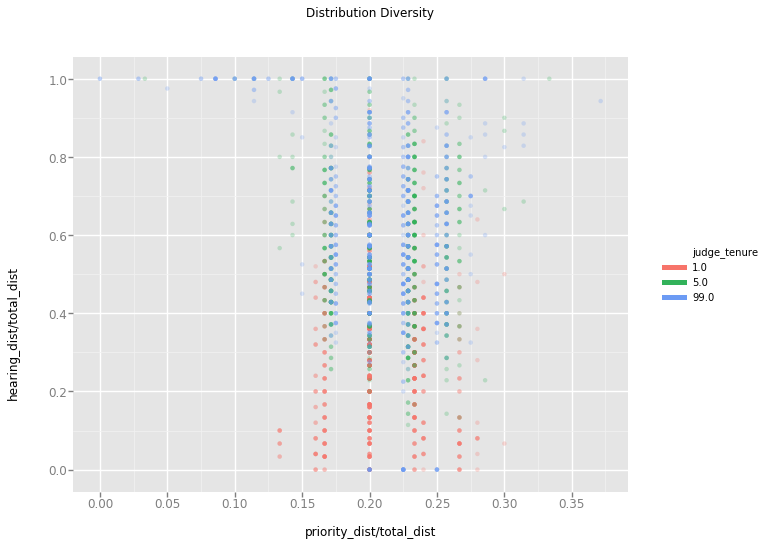

<ggplot: (282678676)>

In [15]:
ggplot(aes(x='priority_dist/total_dist', y='hearing_dist/total_dist', color = 'judge_tenure'), data=batches_df) +\
    geom_point(alpha=0.25) +\
    ggtitle("Distribution Diversity")

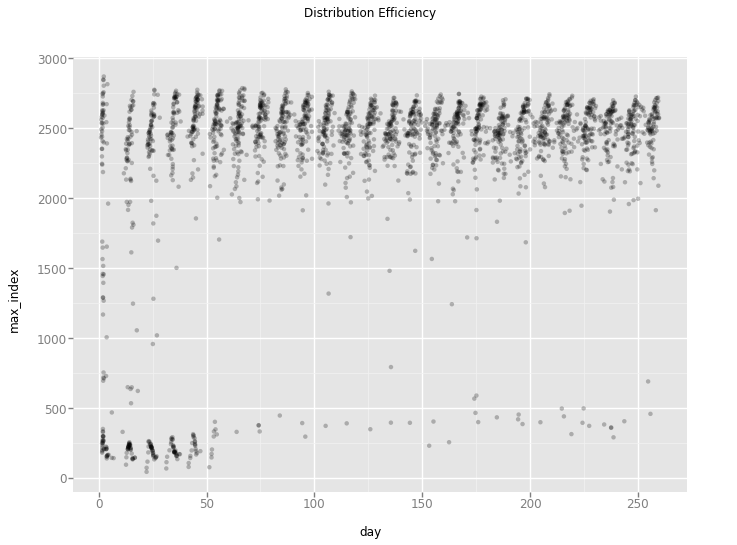

<ggplot: (286099909)>

In [16]:
ggplot(aes(x='day', y='max_index'), data=batches_df) +\
    geom_point(alpha=0.25) +\
    ggtitle("Distribution Efficiency")

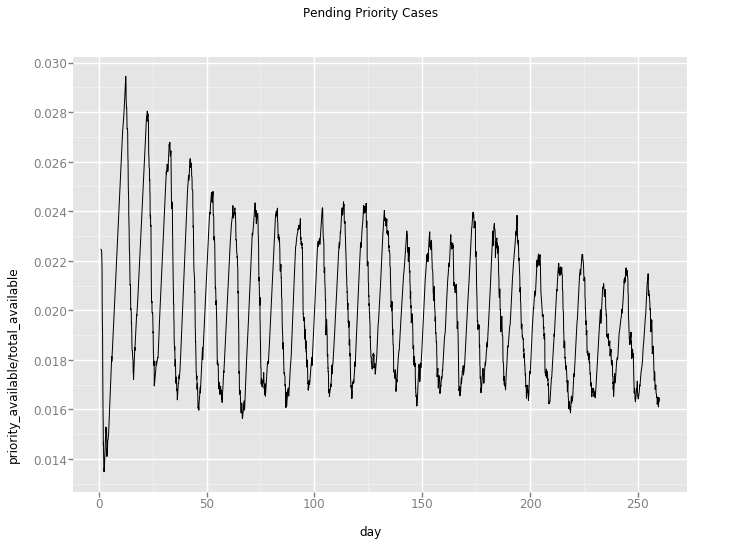

<ggplot: (-9223372036567976830)>

In [17]:
ggplot(aes(x='day', y='priority_available/total_available'), data=batches_df) +\
    geom_line() +\
    ggtitle("Pending Priority Cases")

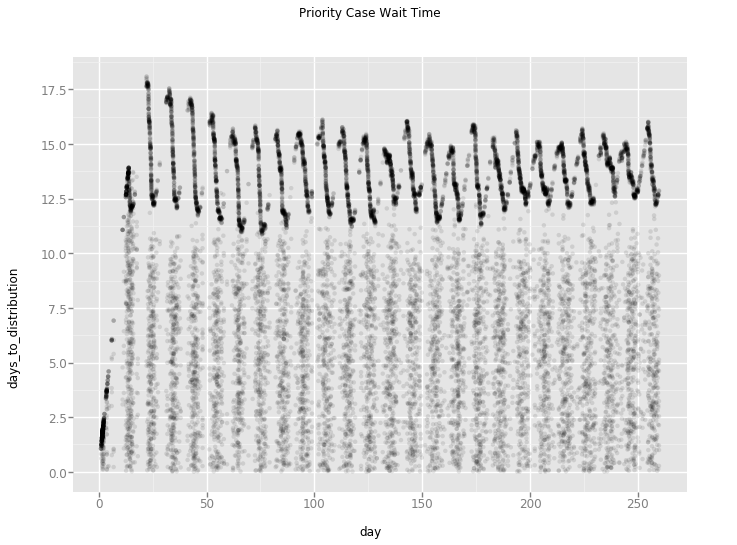

<ggplot: (286931029)>

In [18]:
ggplot(aes(x='day', y='days_to_distribution'), data=priority_cases_df) +\
    geom_point(alpha=0.1) +\
    ggtitle("Priority Case Wait Time")